## References

https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

In [1]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [2]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.10.1


In [3]:
# Constant Values 
TICKER = "AAPL"
START_DATE = "2022-11-01"
END_DATE = "2024-05-31"
START_PREDICTION_DATE = "2024-05-31"
END_PREDICTION_DATE = "2024-11-20"
TARGET_VARIABLE = "Adj Close" # choose from "Adj Close", "Close", "High", "Low", "Open", and "Volume"
DAYS_TO_PREDICT = 120 # Days into the future that we want to predict
DAYS_BEFORE =  8 # Days from the past to be used, pick one from [365, 120, 60, 30, 14] and run the whole notebook to attain the results. 


NUM_EPOCHS = 100 # Number of training iterations
TRAINING_PCNT = 0.90

In [4]:
# Getting information about the company
company = yf.Ticker(TICKER)
# company.info

In [5]:
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
prediction_data = yf.download(TICKER, start=START_PREDICTION_DATE, end=END_PREDICTION_DATE)
data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-05-23 00:00:00+00:00,186.458801,186.880005,191.000000,186.630005,190.979996,51005900
2024-05-24 00:00:00+00:00,189.551804,189.979996,190.580002,188.039993,188.820007,36294600
2024-05-28 00:00:00+00:00,189.561798,189.990005,193.000000,189.100006,191.509995,52280100
2024-05-29 00:00:00+00:00,189.861115,190.289993,192.250000,189.509995,189.610001,53068000
2024-05-30 00:00:00+00:00,190.858856,191.289993,192.179993,190.630005,190.759995,49947900


In [6]:
prediction_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-05-31 00:00:00+00:00,191.816681,192.250000,192.570007,189.910004,191.440002,75158300
2024-06-03 00:00:00+00:00,193.592682,194.029999,194.990005,192.520004,192.899994,50080500
2024-06-04 00:00:00+00:00,193.911957,194.350006,195.320007,193.029999,194.639999,47471400
2024-06-05 00:00:00+00:00,195.428528,195.869995,196.899994,194.869995,195.399994,54156800
2024-06-06 00:00:00+00:00,194.041672,194.479996,196.500000,194.169998,195.690002,41181800


In [7]:
# checking for missing value
data.isnull().sum()

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[TARGET_VARIABLE].values.reshape(-1,1))

In [9]:
'''
Creating sequences

LSTM models require input to be in a sequenced format.

'''

X = []
y = []

for i in range(DAYS_BEFORE, len(data_scaled)):
    X.append(data_scaled[i-DAYS_BEFORE:i, 0])
    y.append(data_scaled[i, 0])

In [10]:
train_size = int(len(X) * TRAINING_PCNT)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
len(X_train)

349

In [11]:
# Reshape the data for the LSTM

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=20,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=20))
model.add(Dense(units=1))

# Attention mechanism ignored here
# Only raw LSTM is used here

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 20)             1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [14]:
# No callbacks implemented

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=NUM_EPOCHS,batch_size=32, validation_split=0.20)

Epoch 1/100
9/9 [==============================] - 4s 104ms/step - loss: 0.1921 - val_loss: 0.1307
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0440 - val_loss: 0.0039
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 4/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0122 - val_loss: 0.0049
Epoch 5/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 8/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 9/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 11/100
9/9 [

In [15]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

2/2 [==============================] - 0s 5ms/step - loss: 0.0037
Test Loss:  0.0036829018499702215


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)
print(y_pred)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


2/2 [==============================] - 1s 3ms/step
[[0.63028324]
 [0.6265974 ]
 [0.62225175]
 [0.6195409 ]
 [0.61586404]
 [0.62491465]
 [0.64120233]
 [0.6524236 ]
 [0.6548735 ]
 [0.649678  ]
 [0.6394281 ]
 [0.62345344]
 [0.6084969 ]
 [0.5960569 ]
 [0.5914589 ]
 [0.5943099 ]
 [0.5999325 ]
 [0.6133554 ]
 [0.6232096 ]
 [0.62889504]
 [0.63712585]
 [0.662977  ]
 [0.6907703 ]
 [0.7186173 ]
 [0.74359053]
 [0.7659683 ]
 [0.78208745]
 [0.79725456]
 [0.8102656 ]
 [0.82514554]
 [0.840021  ]
 [0.8526628 ]
 [0.864293  ]
 [0.87569416]
 [0.88226235]
 [0.8785605 ]
 [0.8764393 ]
 [0.87465066]
 [0.8740562 ]]
Mean Absolute Error:  0.05060557992051293
Root Mean Square Error:  0.06068691155094283


In [17]:
predicted_prices = []
y_test_actual = []
for item in y_pred:
  predicted_prices.append(scaler.inverse_transform([item])[0,0])

for item in y_test:
  y_test_actual.append(scaler.inverse_transform([[item]])[0,0])

train_size = int(len(X) * TRAINING_PCNT)
predicted_df = pd.DataFrame()
predicted_df['Actual Value'] = data[TARGET_VARIABLE].iloc[train_size+DAYS_BEFORE:]
predicted_df['Actual Value Y test'] = y_test_actual
predicted_df['Predicted Value'] = predicted_prices
print(len(y_test_actual))

39


<Axes: xlabel='Date'>

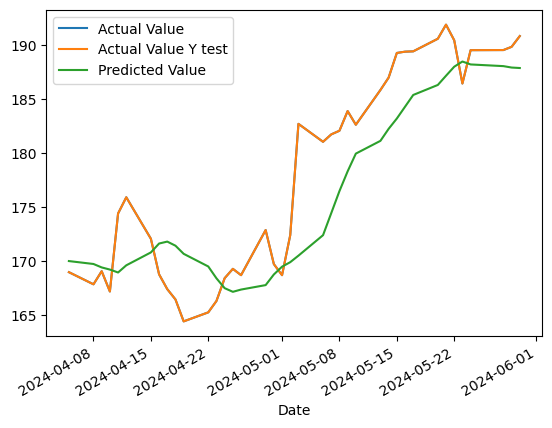

In [18]:
predicted_df.plot()

In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
prediction_data = yf.download(TICKER, start=START_PREDICTION_DATE, end=END_PREDICTION_DATE)
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[TARGET_VARIABLE].values.reshape(-1,1))
predicted_scaled = scaler.fit_transform(prediction_data[TARGET_VARIABLE].values.reshape(-1,1))
data[TARGET_VARIABLE].iloc[-1]

[*********************100%***********************]  1 of 1 completed


Ticker
AAPL    190.858856
Name: 2024-05-30 00:00:00+00:00, dtype: float64

In [20]:
predicted_prices_from_predicted = []
predicted_prices_from_actual = []

current_batch = data_scaled[-DAYS_BEFORE:].reshape(1,DAYS_BEFORE,1) #select the correct date is important

for i in range(DAYS_TO_PREDICT):  # Predicting 120 days (test size but now we are using predicted values to help)
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices_from_predicted.append(scaler.inverse_transform(next_prediction)[0, 0])

    if DAYS_BEFORE-i>0:
        current_batch_2 = data_scaled[-(DAYS_BEFORE-i):]
        current_batch_3 = predicted_scaled[:i]
        current_batch_2 = np.append(current_batch_2, current_batch_3)
        next_prediction_from_actual = model.predict(current_batch_2.reshape(1,DAYS_BEFORE,1))
    else: 
        current_batch_3 = predicted_scaled[i-DAYS_BEFORE:i]
        next_prediction_from_actual = model.predict(current_batch_3.reshape(1,DAYS_BEFORE,1))
    predicted_prices_from_actual.append(scaler.inverse_transform(next_prediction_from_actual)[0, 0])

1/1 [==============================] - 0s 20ms/step


In [21]:
len(prediction_data[TARGET_VARIABLE])

120

In [22]:
predicted_prices_from_predicted

[230.71405,
 230.62836,
 230.49916,
 230.3391,
 230.13438,
 229.91106,
 229.69511,
 229.49432,
 229.3177,
 229.15231,
 228.98871,
 228.83044,
 228.67918,
 228.53519,
 228.39787,
 228.26646,
 228.14043,
 228.01942,
 227.90334,
 227.79193,
 227.685,
 227.58226,
 227.4835,
 227.38855,
 227.29721,
 227.20927,
 227.12465,
 227.0431,
 226.96455,
 226.88884,
 226.81583,
 226.74542,
 226.6775,
 226.61195,
 226.54866,
 226.48756,
 226.42853,
 226.37149,
 226.31639,
 226.26312,
 226.21161,
 226.16179,
 226.1136,
 226.06697,
 226.02188,
 225.97823,
 225.93593,
 225.895,
 225.85538,
 225.81697,
 225.77975,
 225.74373,
 225.70879,
 225.67493,
 225.64212,
 225.6103,
 225.57944,
 225.54953,
 225.5205,
 225.49236,
 225.46504,
 225.43854,
 225.41283,
 225.38786,
 225.36365,
 225.34012,
 225.31729,
 225.29514,
 225.27362,
 225.25272,
 225.2324,
 225.2127,
 225.19354,
 225.17494,
 225.15686,
 225.13931,
 225.12225,
 225.10567,
 225.08955,
 225.07388,
 225.05867,
 225.04388,
 225.02951,
 225.01552,
 225.0

In [23]:
predicted_df=pd.DataFrame()
predicted_df['Actual Value'] = prediction_data[TARGET_VARIABLE]
predicted_df['Predicted Value'] = predicted_prices_from_predicted
predicted_df['Predicted Value from Actual'] = predicted_prices_from_actual

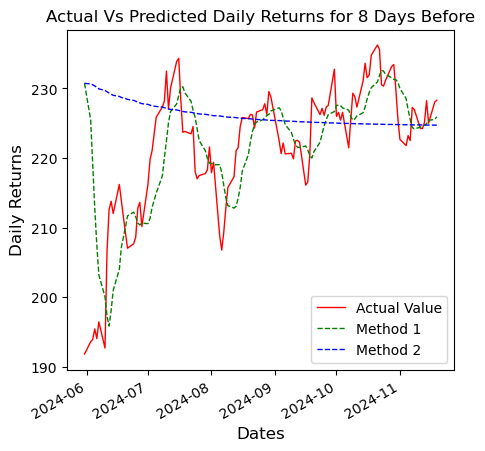

In [24]:
plt.figure(figsize=(5,5))
# data[TARGET_VARIABLE].plot(color="red", linewidth=2)
predicted_df['Actual Value'].plot(color="red", linewidth=1)
predicted_df['Predicted Value from Actual'].plot(color="green", linestyle="--", linewidth=1,  label="Method 1")
predicted_df['Predicted Value'].plot(color="blue", linestyle="--", linewidth=1, label="Method 2")
plt.xlabel("Dates", fontsize = 12)
plt.ylabel("Daily Returns", fontsize = 12)
plt.title("Actual Vs Predicted Daily Returns for "+str(DAYS_BEFORE) +" Days Before", fontsize = 12)
plt.legend()